# Pseudo-potential method for Silicon

This notebook applies the Pseudo-potential to a Silicon crystal.

## Theory

Valence electrons energy levels in a crystal can be modelled by:

$$(-\frac{1}{2}\nabla^2 + V(\vec{r}))\psi(\vec{r}) = E\psi(\vec{r})\tag{1}$$

where $V(\vec{r})$ is potential that follows the periodic structure of the crystal.

From Bloch's theorem (Griffiths, 2018, p. 239), eigenstates can be written as:

$$\psi_{\vec{k}}(\vec{r}) = e^{i\vec{k}\cdot\vec{r}}u_{\vec{k}}(\vec{r})\tag{2}$$

where $u_{\vec{k}}(\vec{r})$ is a periodic function (like the potential) and $\vec{k}$ is a label of the eigenstate. Under periodic boundary conditions $\vec{k}$ is constrained to  $\vec{k} = \frac{m_1\vec{b_1} + m_2\vec{b_2} + m_3\vec{b_3}}{N}$ where $\vec{b_1}$,$\vec{b_2}$,$\vec{b_2}$ are the reciprocal vectors of the system, N is the number of lattice vectors in the periodic region and $m_1$,$m_2$,$m_3$ are integers less than N.

A common method to solve this problem is the variational method. Due to Bloch's theorem, an apropriate basis for states labeled by $\vec{k}$ are plane waves:

$$\psi_{\vec{k} + \vec{K}} = e^{i(\vec{k} + \vec{K})\cdot\vec{r}}\tag{3}$$

However, due to the strength of the potential near the nucleus, this method requires an inefficient basis size. One method to overcome this is the pseudopotential method, this changes the potential near the nucleus to a weaker potential that gives the same results. This is usually done by fitting experimental data or using simpler numerical resutls (Thijssen, 2013, p. 144)( example ref). In (Thijssen, 2013, p. 146) and (Chelikowsky,1974,p. 5095) this method is described for Silicon (note that it uses the compact picture of energy levels, so the label $\vec{k}$ is not unique). This is what is implemented bellow.

## Implementation

This implementation was relatively simple. Once I got it working I used some of Medlar's methods from (Medlar,2016) to make it more efficient.

In [9]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

The following code implements the method specified in (Thijssen, 2013, p. 144) and (Chelikowsky,1974,p. 5095).

In [10]:
#lattice parameter 
a = 5.43*1.88973 

#matrix used to map basis numbers to unscaled vectors
basisMatrix = np.array([[-1, 1, 1],[1, -1, 1],[1, 1, -1]])

In [11]:
#simulation parameters
nLim = 2
KsNum = (2*nLim + 1)**3

#finds Ks
Ks = []
for l,m,n in itertools.product(range(-nLim,nLim+1), repeat=3):
    Ks.append(np.array([l,m,n])) 

In [12]:
offset = np.ones(3)/8

def V(KSquared):
    """
    Function that finds Fourier components of pseudo-potential.
    """
    if KSquared == 3:
        return -0.1121
    elif KSquared == 8:
        return 0.0276
    elif KSquared == 11:
        return 0.0362
    return 0


def getE(k):
    """
    Finds energy for a given k vector.
    """
    H = np.empty([KsNum, KsNum])
    
    for r, c in itertools.product(range(KsNum), repeat=2):
        if r == c:
            K = basisMatrix @ Ks[r]
            H[r,c] = 0.5*(2*np.pi*np.linalg.norm(k+K)/a)**2
        else:
            deltaK = basisMatrix @ (Ks[r] - Ks[c]) 
            VCoef = V(deltaK @ deltaK)
            if VCoef == 0:
                H[r,c] = 0
            else:
                H[r,c] = VCoef * np.cos(2*np.pi*deltaK @ offset)

    #find energies and return smallest 8 
    eigvals = np.linalg.eigvals(H)
    eigvals.sort()
    return eigvals[:8]

The following code find the energy bands between the points $\Gamma = \vec{0}$ and $X = \frac{2\pi}{a}\vec{x}$. Remember that these bands are in fact made up of finite set of energy states for realistic boundary conditions (here periodic boundary conditions were chosen).

In [13]:
#find energies
ks = [np.array([i/20,0,0]) for i in range(0,21)] 
Es = np.zeros([8,len(ks)])

for j,k in enumerate(ks):
    energyArr = getE(k)
    for i in range(8):
        Es[i,j] = energyArr[i]


Text(0, 0.5, '$E$')

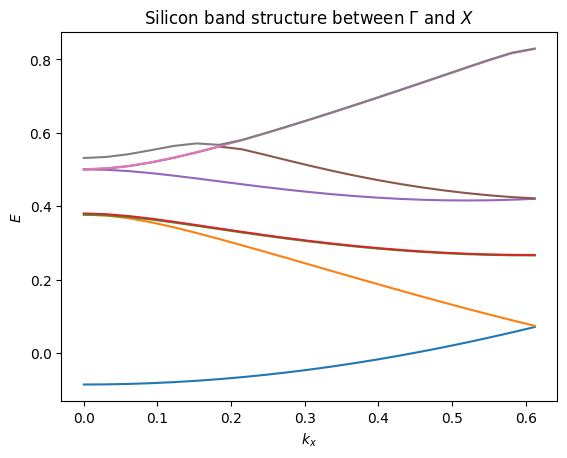

In [14]:
#find x components and scale appropriately
kx = list(map(lambda k: k[0],2*np.pi*np.array(ks)/a)) 

#graph energy levels
for i in range(8):
    plt.plot(kx,Es[i])

plt.title(r"Silicon band structure between $\Gamma$ and $X$")
plt.xlabel(r"$k_x$")
plt.ylabel(r"$E$")




The following code finds the Fermi surface of Silicon. For an introduction to Fermi surfaces see (Dugdale, 2016); for a example of finding the Fermi surface on copper see (Burdick, 1962). The surface coresponds to the surface bounded by the volume that the points on the graph make up.

Need to go into Fermi energy more clearly (Kittel)

In [75]:
#N value for periodic boundary conditions 
N = 6
halfN = 3

#use reduced scheme its better for visualisation

#find energy levels for allowed K points 
KEAllowed = [[] for i in range(8)]
for l,m,n in itertools.product(range(-halfN,halfN), repeat=3): 
    K = basisMatrix@np.array([l,m,n])/halfN
    Es = getE(K)
    for i,Ei in enumerate(getE(K)): 
        KEAllowed[i].append(list(K)+[Ei])


KeyboardInterrupt: 

In [72]:

#sort the K's by energy
KEAllowed[0] = sorted(KEAllowed[0],key=lambda l: l[3]) 

#find K's occupied at 0 temp; Silicon has 4 valence electrons meaning the smallest 2*N^3 K states are filled
KAllowed = list(map(lambda KE: KE[:3],KEAllowed[0]))
KOccupied = KAllowed[:2*N**3]


[[ 0.          0.          0.        ]
 [-0.61232259 -0.61232259  0.61232259]
 [ 0.61232259 -0.61232259 -0.61232259]
 [-0.61232259  0.61232259 -0.61232259]
 [ 0.          0.         -1.22464518]
 [ 0.         -1.22464518  0.        ]
 [-1.22464518  0.          0.        ]
 [-0.61232259 -0.61232259 -0.61232259]
 [ 0.20410753 -0.20410753  0.20410753]
 [-0.20410753  0.20410753  0.20410753]
 [ 0.20410753  0.20410753 -0.20410753]
 [-0.20410753 -0.20410753  0.20410753]
 [-0.20410753  0.20410753 -0.20410753]
 [ 0.20410753 -0.20410753 -0.20410753]
 [-0.20410753 -0.20410753 -0.20410753]
 [ 0.20410753  0.20410753  0.20410753]
 [-0.40821506  0.40821506 -0.40821506]
 [-0.40821506  0.40821506  0.40821506]
 [-0.40821506 -0.40821506  0.40821506]
 [ 0.40821506  0.40821506 -0.40821506]
 [ 0.40821506 -0.40821506 -0.40821506]
 [ 0.40821506 -0.40821506  0.40821506]
 [-0.81643012  0.40821506  0.40821506]
 [-0.40821506  0.81643012 -0.40821506]
 [ 0.40821506  0.40821506 -0.81643012]
 [-0.40821506 -0.40821506

Text(0.5, 0.92, 'Fermi surface of Silicon in K-space')

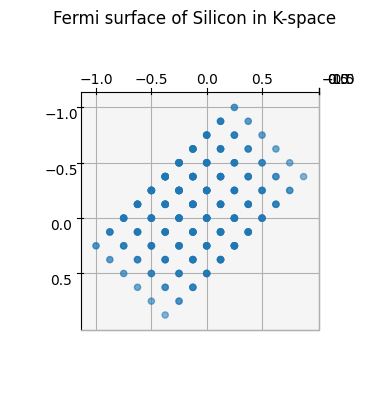

In [76]:
#graph results
KOccupied = 2*np.pi*np.array(KOccupied)/a
ax = plt.axes(projection='3d')
ax.set_proj_type('ortho')
ax.scatter(KOccupied[:,0], KOccupied[:,1], KOccupied[:,2])
ax.view_init(90, 0)
ax.set_title("Fermi surface of Silicon in K-space")


## Reference

Thijseen J., 2013. Computational Physics. Cambridge: Cambridge University Press

Medlar, W., 2016. Pseudopotential-Derived Band Structure of Silicon. [Online] 
Available at: https://gist.github.com/wmedlar/12c13ded690b476739ab#file-pseudopotential-derived-band-structure-of-silicon-ipynb
[Accessed 1 8 2024].

Dugdale S., 2016. Life on the edge: a beginner’s guide to the Fermi surface. Physica Scripta, Phys. Scr. (91 ).

Griffiths D., 2018. Introduction To Quantum Mechanics.  Cambridge: Cambridge University Press

Burdick, G., 1962. Energy Band Structure of Copper. Physical Review, Volume 129, pp. 138-150.

James Chelikowsky; M. Cohen, 1974. Electronic structure of silicon. Physical review B, Volume 10, pp. 5095-5107.

